In [464]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import math
from matplotlib.pyplot import figure


In [465]:
gray_img = cv2.imread('monkey_image.png', cv2.IMREAD_GRAYSCALE)

In [466]:
pd_im=pd.DataFrame(gray_img)

## Q1: 1, Histogram of the Image

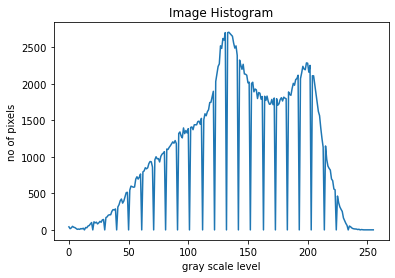

In [467]:
histg = cv2.calcHist([gray_img],[0],None,[256],[0,256])
plt.plot(histg)
plt.xlabel('gray scale level')
plt.ylabel('no of pixels')
plt.title('Image Histogram')
plt.show()

In [468]:
one_col = gray_img.reshape(512*512,1)
pd_col = pd.DataFrame(one_col)


Text(0.5, 1.0, 'Image Histogram pdf')

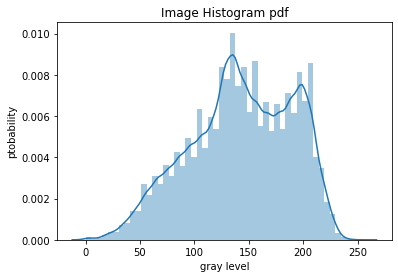

In [469]:
sns.distplot(one_col) #plot pdf by histogram
plt.xlabel('gray level')
plt.ylabel('ptobability')
plt.title('Image Histogram pdf')

In [470]:
pdf_x=(pd_col[0].value_counts()/len(pd_col[0])) #pdf of given image by histogram

# Q1: 2-a,   Implementation of uniform quantization

In [471]:
def findK(b): #calculate k from b
    return 2**b

def findDecisions(k): #find decisions levels
    return np.linspace(0.0, 255.0, num=(int)(k+1))


        
def findRepresentationUniform(decision_list): #find representations levels
    representation_list=[]
    i=0
    for i in range(len(decision_list)-1):
        representation_list.append((decision_list[i]+decision_list[i+1])/2) #represnt_i is the avarge of dec_i and dec_i+1
        i=i+1
    return representation_list

In [585]:

from scipy import integrate

def mseQuant_i(i,dec,rep,pdf): #calculate the MSE of interval i
    mse_i=0
    for x in range(int(math.ceil(dec[i-1])),int(math.floor(dec[i]))):
        if x in pdf.index:
            mse_i+=((x-rep[i-1])**2)*pdf[x]
    return mse_i
    
def mseQuantUniform(b,pdf): #calculate MSE of the quantization of the image
    k=findK(b)
    dec=findDecisions(k)
    rep=findRepresentationUniform(dec)
    mse_tot=0
    for i in range(1,int(k)+1):
       mse_tot=mse_tot+mseQuant_i(i,dec,rep,pdf)
    return mse_tot

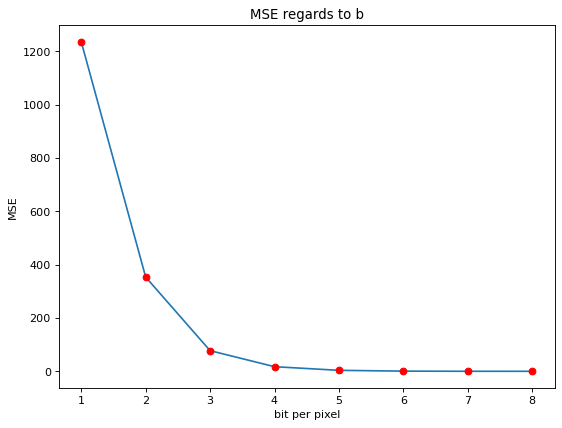

In [586]:
bit_arr=pd.Series(range(1,9))
bit_mse=bit_arr.apply(lambda x:mseQuantUniform(x,pdf_x))
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(bit_arr, bit_mse)
plt.plot(bit_arr, bit_mse,'ro')
plt.title('MSE regards to b')
plt.xlabel('bit per pixel')
plt.ylabel('MSE')
plt.show()


## Q1: 2-b

Press double click on the figure to zoom in.
Decision levels- Green Diamonds
Representation levels- Red *


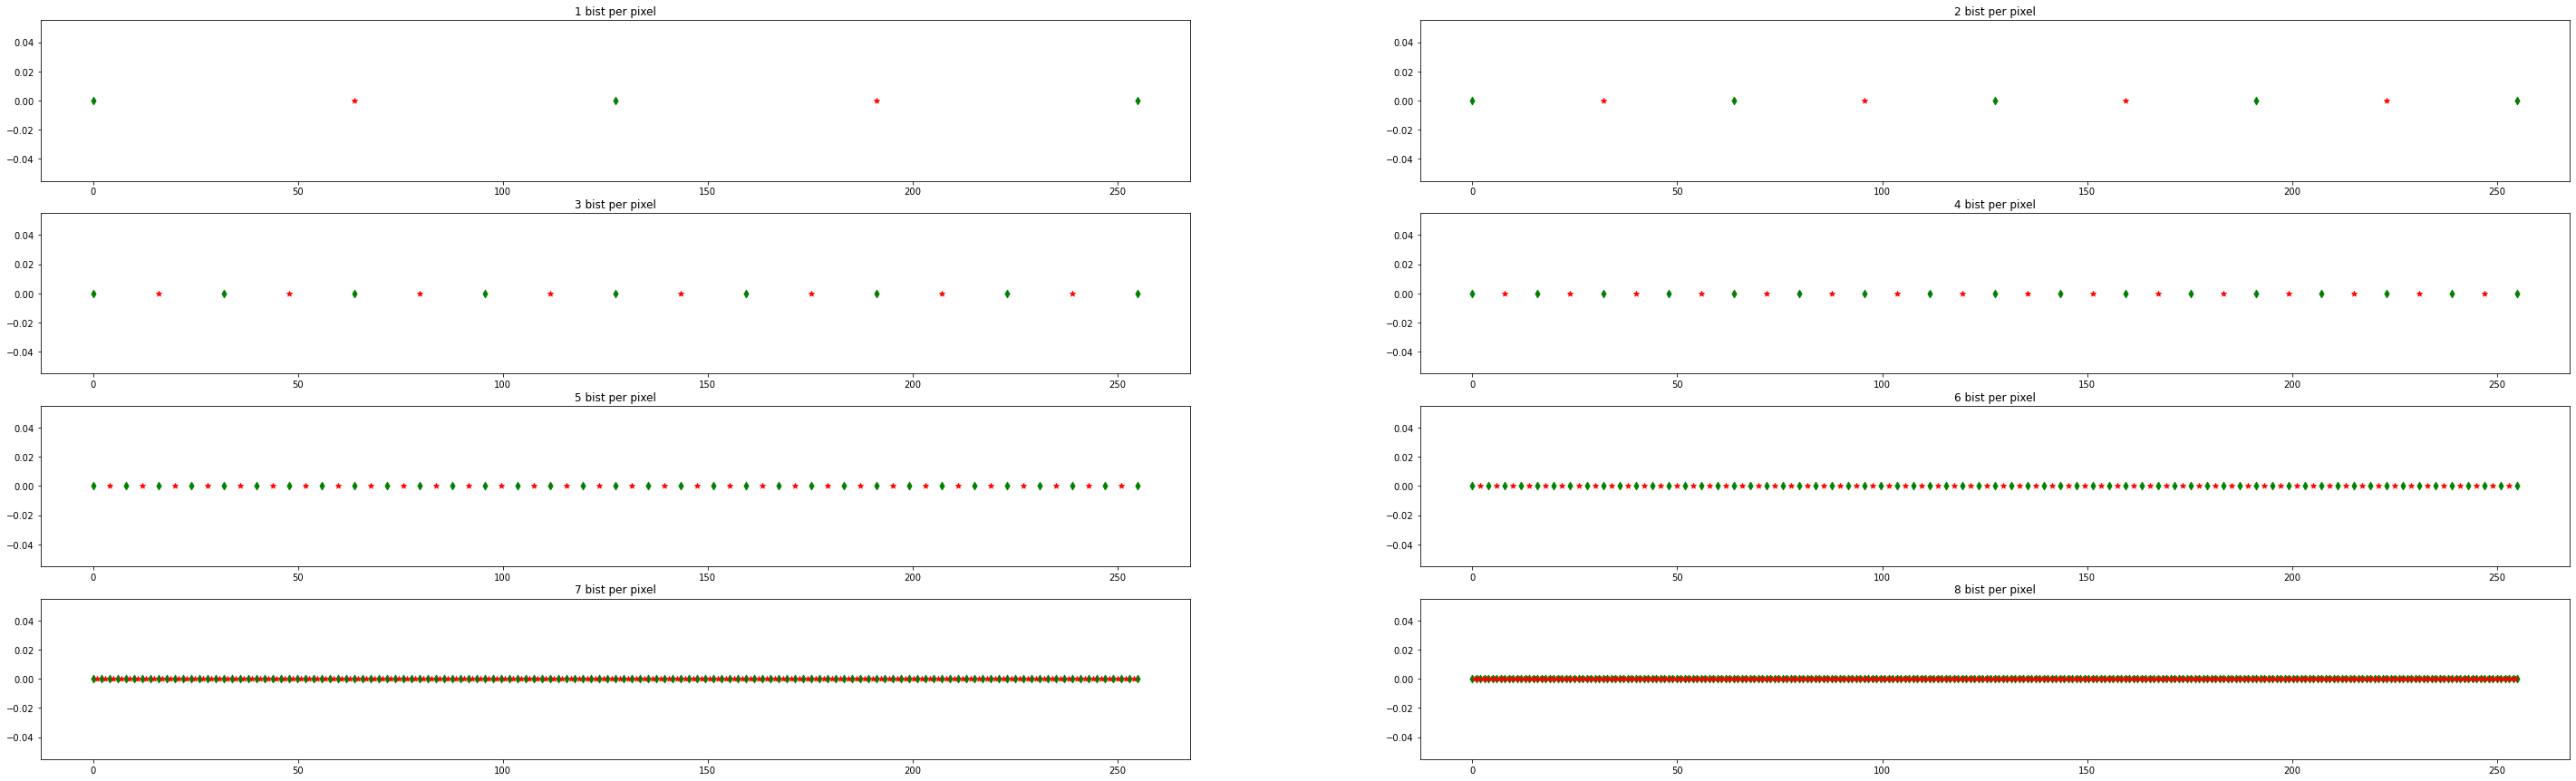

In [587]:
fig,axes=plt.subplots(nrows=4, ncols=2,figsize=(50,15))
b=1
print("Press double click on the figure to zoom in.")
print("Decision levels- Green Diamonds")
print("Representation levels- Red *")
for row in range(0,4):
    for col in range(0,2):
        k=findK(b)
        dec=findDecisions(k)
        rep=findRepresentationUniform(dec)
        y_dec=np.zeros(len(dec))
        axes[row][col].scatter(dec,y_dec,c='green', marker='d')
        y_rep=np.zeros(len(rep))
        axes[row][col].scatter(rep,y_rep, c='red', marker='*')
        axes[row][col].set_title(str(b)+" bist per pixel")
        b+=1
    
    

# Q1: 3 , Implementation of Max-Lloyd algorithm

In [608]:
import random
def findRepOptimal_i(i,dec,pdf): #find optimal representation in interval i given descision levels
    sum1=0
    sum2=0
    for x in range(int(math.ceil(dec[i])),int(math.floor(dec[i+1]))):
        if x in pdf.index:
            sum1+=x*pdf[x]
            sum2+=pdf[x]
    if sum2 == 0: #This is an empty cluster
        return dec[i]+random.random()*(dec[i+1]-dec[i])
    return sum1/sum2
    #Explantion to strategy- choosing random point when cluster is empty:
    #This is a strategy to handle empty cluster
    #We chose this strategy to handle empty cluster by represent this empty
    #cluster with random point in the interval. 
    #The reason is beacuse adding represention (random from interval) can only help us
    #decrease the MSE, by that it's better than removing the cluster and dont add represntation at all.
    #This strategy also has disadvantage, it can make much empty cluster by that where there can be only one cluster. 
    #But the choice for random seems to us the best strategy for 256-gray scale image with 512*512 pixels 
    #(by that we mean random probably will decrease the MSE).
    

def findRepresentationOptimal(decision_list,pdf): #find optimal representations levels 
    representation_list=[]
    i=0
    while i<len(decision_list)-1:
        #represnt_i is the optimal representatin in intervalof dec_i and dec_i+1, i.e cener of mass as we saw in class
        representation_list.append(findRepOptimal_i(i,decision_list,pdf)) 
        i=i+1
    return representation_list

def mseByDecRep(dec,rep,pdf): # find the MSE by decision and represantation levels and pdf
    mse_tot=0
    for i in range(1,len(dec)):
       mse_tot=mse_tot+mseQuant_i(i,dec,rep,pdf)
    return mse_tot

def findDecByRep(first,last,rep):#find optimal decisions by representations levels
    dec=[first]
    for i in range(1,len(rep)):
        dec.append((rep[i-1]+rep[i])/2)
    dec.append(last)
    return dec

def maxLloyd(pdf,decisions_list,epsilon): # max lloyd alg implementation
    # 1.  Initialization: set\guess decision levels (given as parameter )
    # 2.  Compute the optimal representation levels for decision levels
    #3. Compute the optimal decision levels for representation levels
    #4. If stopping criteria has not met, return to (2) (using while condition)
    represention_list=findRepresentationOptimal(decisions_list,pdf)
    #decisions_list=findDecByRep(decisions_list[0],decisions_list[-1],represention_list)
    last_mse=mseByDecRep(decisions_list,represention_list,pdf) #intialize as the first iteration MSE
    #round_iter=1
    while(True):
        
        decisions_list=findDecByRep(decisions_list[0],decisions_list[-1],represention_list)
        represention_list=findRepresentationOptimal(decisions_list,pdf)
        #round_iter+=1
        curr_mse=mseByDecRep(decisions_list,represention_list,pdf)
        if abs(last_mse-curr_mse)<epsilon:
            break
        last_mse=curr_mse
    return decisions_list,represention_list #,round_iter
    

In [615]:
k=findK(9)
dec_init=findDecisions(k)
dec,rep=maxLloyd(pdf_x,dec_init,1)
mseByDecRep(dec,rep,pdf_x)

0

## Q1: 4-a

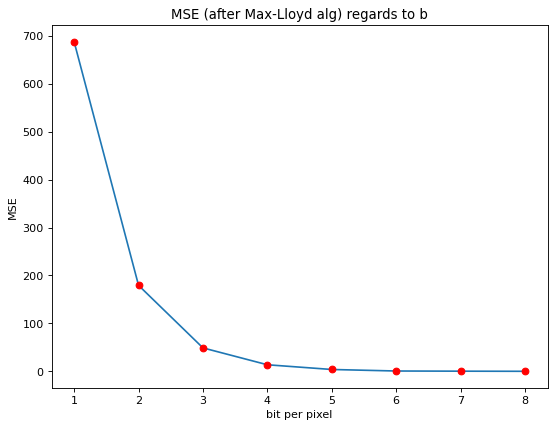

In [601]:
epsi=0.0001 #define epsilon

def helperForFindingMSE(b,pdf,epsilon):
    k=findK(b)
    dec_init=findDecisions(k)
    dec,rep=maxLloyd(pdf,dec_init,epsilon)
    return mseByDecRep(dec,rep,pdf)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
bit_arr=pd.Series(range(1,9))
bit_mse=bit_arr.apply(lambda b:helperForFindingMSE(b,pdf_x,epsi))
plt.plot(bit_arr, bit_mse)
plt.plot(bit_arr, bit_mse,'ro')
plt.title('MSE (after Max-Lloyd alg) regards to b')
plt.xlabel('bit per pixel')
plt.ylabel('MSE')
plt.show()


## Q1: 4-b

Press double click on the figure to zoom in.
Decision levels- Green Diamonds
Representation levels- Red *


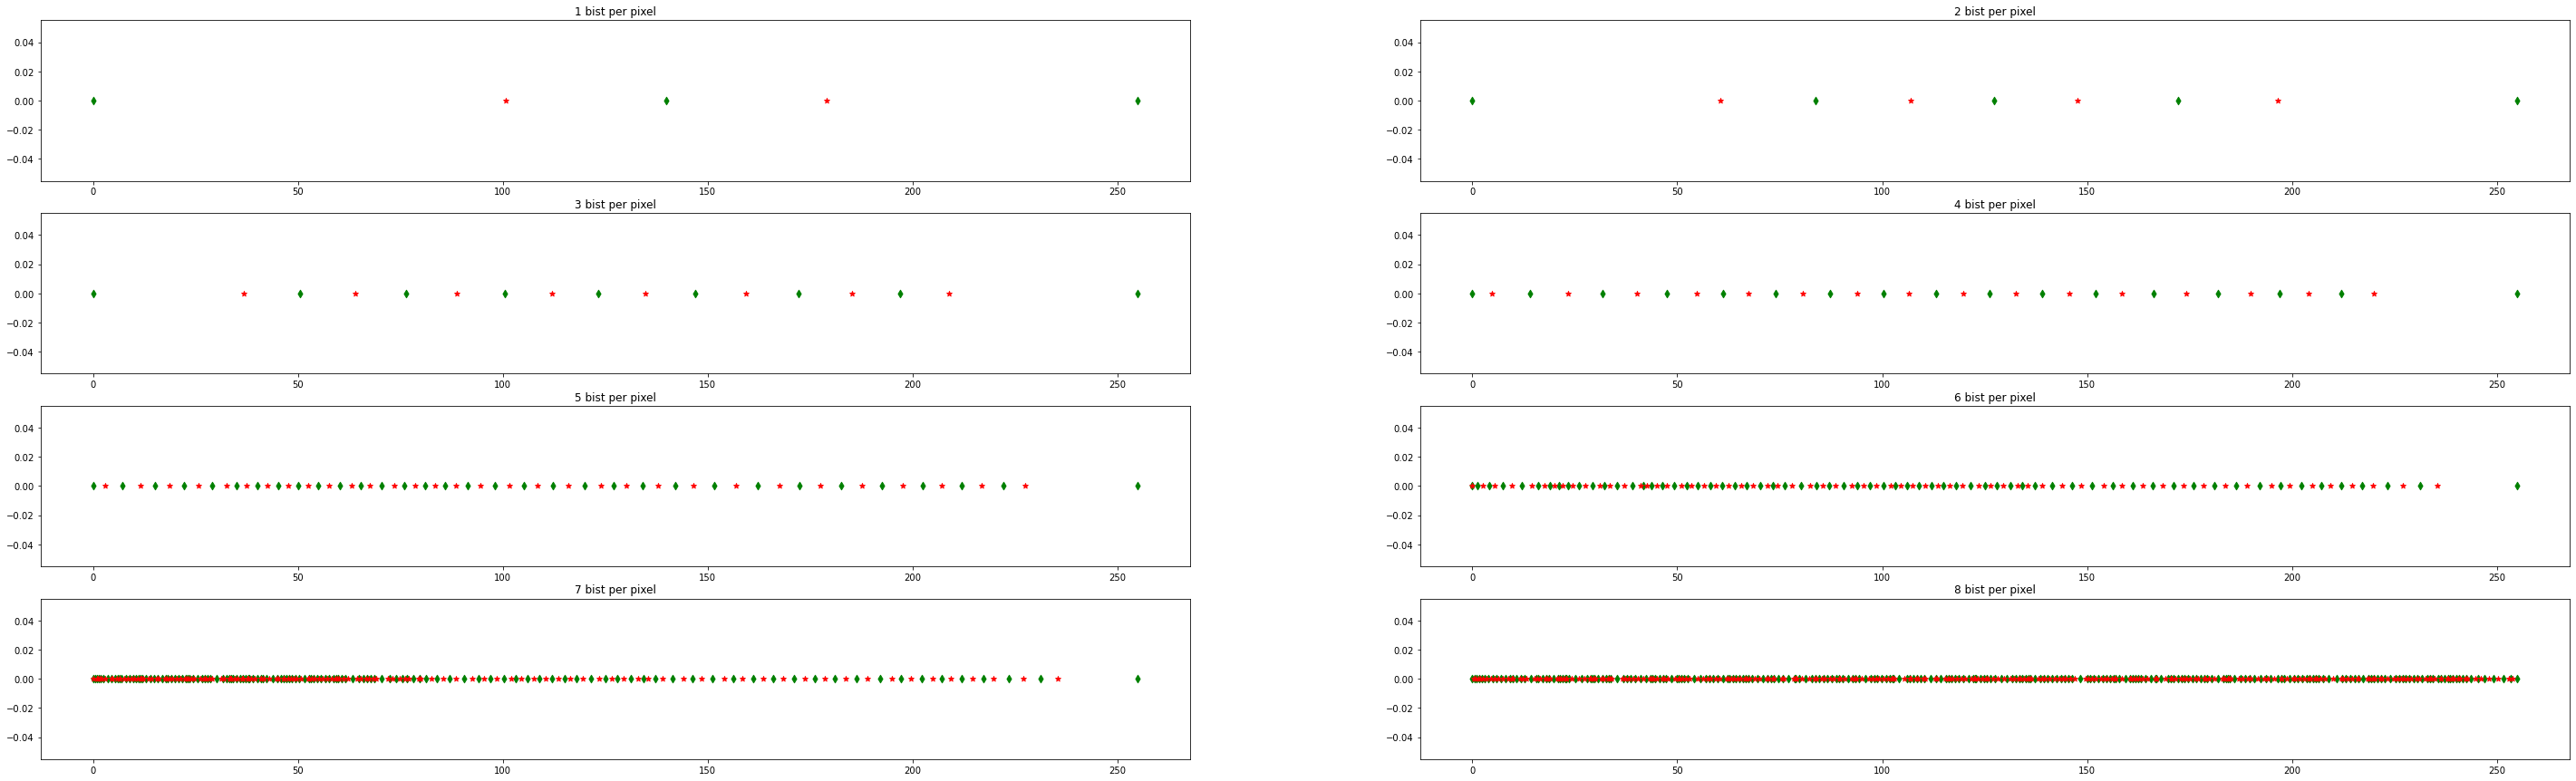

In [602]:

fig,axes=plt.subplots(nrows=4, ncols=2,figsize=(50,15))
b=1
print("Press double click on the figure to zoom in.")
print("Decision levels- Green Diamonds")
print("Representation levels- Red *")
for row in range(0,4):
    for col in range(0,2):
        k=findK(b)
        dec_init=findDecisions(k)
        dec,rep=maxLoyed(pdf_x,dec_init,epsi)
        y_dec=np.zeros(len(dec))
        axes[row][col].scatter(dec,y_dec,c='green', marker='d')
        y_rep=np.zeros(len(rep))
        axes[row][col].scatter(rep,y_rep, c='red', marker='*')
        axes[row][col].set_title(str(b)+" bist per pixel")
        b+=1
  

## Q1: 4-c

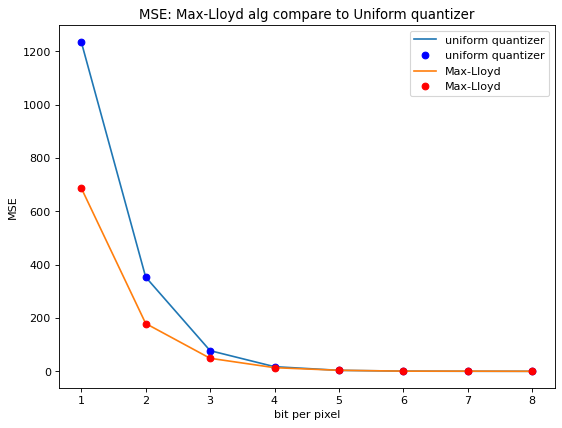

In [603]:

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
bit_arr1=pd.Series(range(1,9))
bit_mse=bit_arr1.apply(lambda x:mseQuantUniform(x,pdf_x))
plt.plot(bit_arr1, bit_mse, label='uniform quantizer')
plt.plot(bit_arr1, bit_mse,'ro', label='uniform quantizer',color='blue')


bit_arr2=pd.Series(range(1,9))
bit_mse=bit_arr2.apply(lambda b:helperForFindingMSE(b,pdf_x,epsi))
plt.plot(bit_arr2, bit_mse,label='Max-Lloyd')
plt.plot(bit_arr2, bit_mse,'ro',label='Max-Lloyd')
plt.title('MSE: Max-Lloyd alg compare to Uniform quantizer')
plt.xlabel('bit per pixel')
plt.ylabel('MSE')

plt.legend()
plt.show()

As we can see on the figure there are differences between the two ways to quantize the image.
Both ways (uniform quantization and max-lloyd) MSE's  are approaching zero as we get more bits to our budget, but
the max lloyd is allways smaller or equal to the uniform quantization.
The reason is beacuse max-lloyd alg find each iteration other decision and represintation levels which are the optimal.
It fix one of them and find the optimal given the fix one and than replace roles (optimal decision levels given represantion or
optimal represantion given decision).
That way we know we are heading to a minimum point (optimal regarding minimize the MSE so the minimum is regarding the MSE).
It can be a local minimum too, but still we started from the uniform quantizion. So, the MSE by the max-lloyd will be
smaller than the uniform as we heading to the minimum by each iteration.It also can be equal if the uniform quantization (the initial for our max-lloyd) is seat too close to the minimum point so our epsilon (convergence tolerance) will stop us from continue minimizing. 